In [ ]:
!pip install -U transformers[tf] datasets

In [1]:

import pandas as pd
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification
from transformers import DataCollatorWithPadding
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("mental_health_sentiment.csv")

In [3]:

try:
    df = pd.read_csv("mental_health_sentiment.csv", index_col=0, engine='python', on_bad_lines='skip')
except Exception as e:
    print("Failed to read CSV:", e)

df = df.dropna(subset=["statement", "status"])
df = df.rename(columns={"statement": "text", "status": "label"})

df["text"] = df["text"].astype(str).str.strip()
df = df[df["text"] != ""]
df = df.drop_duplicates(subset=["text", "label"])

encoder = LabelEncoder()
df["label_encoded"] = encoder.fit_transform(df["label"])

class_counts = df["label_encoded"].value_counts()
valid_labels = class_counts[class_counts >= 2].index
df = df[df["label_encoded"].isin(valid_labels)]

X = df["text"].reset_index(drop=True)
y = df["label_encoded"].reset_index(drop=True)

print(f"Data ready. Total samples: {len(df)}. Class distribution:\n{df['label_encoded'].value_counts()}")

Data ready. Total samples: 51093. Class distribution:
label_encoded
3    16040
2    15094
6    10644
0     3623
1     2501
5     2296
4      895
Name: count, dtype: int64


/tmp/ipython-input-3-3363334278.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["label_encoded"] = encoder.fit_transform(df["label"])


In [7]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np


In [8]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Reset indices
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))


In [9]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)


X_train = X_train.astype(str)
X_test = X_test.astype(str)


In [15]:
!pip install numpy==1.24.4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 109.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
blosc2 3.5.0 requires numpy>=1.26, but you have numpy 1.24.4 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.4 which is incompatible.
pymc 5.23.0 requires numpy>=1.25.0, but you have numpy 1.24.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.4 which is

In [17]:
# Tokenizer and HF Dataset
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

train_dataset = Dataset.from_dict({"text": X_train.tolist(), "label": y_train.tolist()})
test_dataset = Dataset.from_dict({"text": X_test.tolist(), "label": y_test.tolist()})

# Tokenize
def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# Force labels to be native int
train_dataset = train_dataset.map(lambda x: {"label": int(x["label"])})
test_dataset = test_dataset.map(lambda x: {"label": int(x["label"])})

# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

# Convert to TensorFlow Datasets
tf_train = train_dataset.to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols="label",
    shuffle=True,
    batch_size=64,
    collate_fn=data_collator,
)

tf_test = test_dataset.to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols="label",
    shuffle=False,
    batch_size=64,
    collate_fn=data_collator,
)

Map:   0%|          | 0/40874 [00:00<?, ? examples/s]

Map:   0%|          | 0/10219 [00:00<?, ? examples/s]

Map:   0%|          | 0/40874 [00:00<?, ? examples/s]

Map:   0%|          | 0/10219 [00:00<?, ? examples/s]

In [12]:
import tensorflow as tf

In [18]:
num_labels = df["label_encoded"].nunique()
model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=num_labels)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)


tf_test = test_dataset.to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols="label",
    shuffle=False,
    batch_size=32,
    collate_fn=data_collator,
)


history = model.fit(
    tf_train,
    validation_data=tf_test,
    epochs=3,
    class_weight=class_weight_dict
)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/3
639/639 [==============================] - 2959s 5s/step - loss: 0.8046 - accuracy: 0.7152 - val_loss: 0.5814 - val_accuracy: 0.7574
Epoch 2/3
639/639 [==============================] - 2906s 5s/step - loss: 0.4708 - accuracy: 0.8001 - val_loss: 0.4880 - val_accuracy: 0.7979
Epoch 3/3
639/639 [==============================] - 2909s 5s/step - loss: 0.3338 - accuracy: 0.8330 - val_loss: 0.5085 - val_accuracy: 0.7984


320/320 [==============================] - 216s 663ms/step
                      precision    recall  f1-score   support

             Anxiety       0.87      0.83      0.85       725
             Bipolar       0.78      0.83      0.80       500
          Depression       0.78      0.71      0.75      3019
              Normal       0.97      0.91      0.94      3208
Personality disorder       0.34      0.84      0.48       179
              Stress       0.69      0.72      0.70       459
            Suicidal       0.69      0.75      0.72      2129

            accuracy                           0.80     10219
           macro avg       0.73      0.80      0.75     10219
        weighted avg       0.82      0.80      0.80     10219



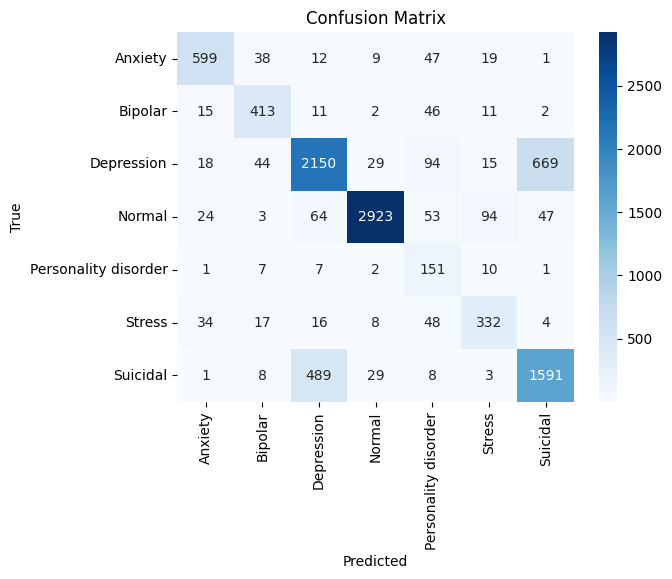

In [19]:
# Evaluate
preds = model.predict(tf_test).logits
y_pred = preds.argmax(axis=1)

print(classification_report(y_test, y_pred, target_names=encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, xticklabels=encoder.classes_, yticklabels=encoder.classes_, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [20]:
model.save_pretrained("distilbert_sentiment_model")
tokenizer.save_pretrained("distilbert_sentiment_model")

('distilbert_sentiment_model/tokenizer_config.json',
 'distilbert_sentiment_model/special_tokens_map.json',
 'distilbert_sentiment_model/vocab.txt',
 'distilbert_sentiment_model/added_tokens.json',
 'distilbert_sentiment_model/tokenizer.json')